<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploring SVMs Using Sklearn


---

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm, linear_model, datasets
from sklearn.model_selection import cross_val_score

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Load the handwritten digits dataset.

In [2]:
# new dataset, handwritten digits!
digits = datasets.load_digits()
digits.data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

1797
64


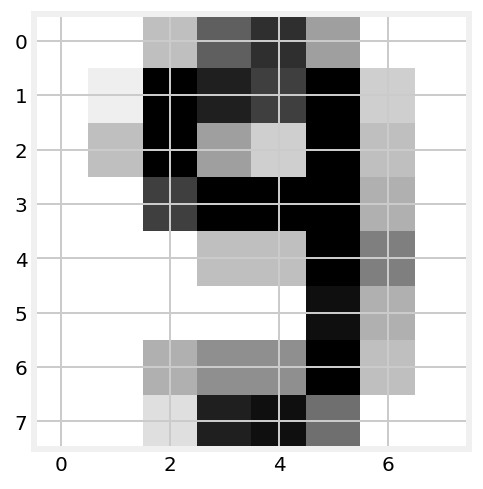

In [3]:
print(len(digits.data))      # 1,797 observations
print(len(digits.data[0]))   # 8 x 8 pixel image

# the number 9
plt.imshow(digits.images[-5], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [4]:
digits.target[-5]# 9

9

In [5]:
np.unique(digits.target)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
digits_X, digits_y = digits.data, digits.target

In [7]:
digits_X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

### 2. Cross-validate a logistic regression on the data.

In [8]:
# What if we just use logistic regression without doing anything?
logistic = linear_model.LogisticRegression()
cross_val_score(logistic, digits_X, digits_y, cv=5, scoring='accuracy').mean()
# OK not bad!!!

0.9210188113360701

### 3. Cross-validate a SVM on the data.

In [9]:
# Let's try a SVM
clf = svm.SVC()
print(cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean())

0.44878680061604637


OOF, we even lost to the logistic regression....
hmm we know that this defaults to the Gaussian (aka radial basis function)
let's try something else

In [10]:
clf = svm.SVC(kernel='linear',decision_function_shape='ovr')
clf.fit(digits_X,digits_y)
print(cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean())

0.9493348726211526


In [11]:
clf = svm.SVC(kernel='poly')
clf.fit(digits_X,digits_y)
print(cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean())

0.9699354903506467


## Gaussian SVM has two parameters, gamma and C

---

### gamma

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning "far" and high values meaning "close". 

The higher the value of gamma, the more it will try to exactly fit the training data set. That will cause over-fitting problems.
- Small gamma: The model is constrained and can under-fit!  It has high bias and low variance.
- Large gamma: The model tries to capture the shape too well: it can over-fit!  It has low bias and high variance.



### C

`C` is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly. `C` can be thought of as the parameter for the soft margin cost function, which controls the influence of each individual support vector.

- Small C: makes the decision surface smooth and simple, a softer margin can under-fit! Gives high bias and low variance.
- Large C: selects more support vectors: can over-fit! Gives a harder margin, low bias and high variance.


### 4. Fit an SVM modifying the default gamma and C.

In [12]:
# note the scale of gamma and C
clf = svm.SVC(gamma=0.001, C=1)
cross_val_score(clf, digits_X, digits_y, cv=5, scoring='accuracy').mean()

0.9716361987950688

### 5. Gridsearch an optimal gamma with C=1.

In [13]:
# Warning SLOWWWWW
from sklearn.model_selection import GridSearchCV

clf = svm.SVC(C=1)
gamma_range = np.logspace(-5, 2, 20)
param_grid = dict(gamma=gamma_range)

grid = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', verbose=1,return_train_score=True)
grid.fit(digits_X, digits_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   44.9s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': array([1.00000e-05, 2.33572e-05, 5.45559e-05, 1.27427e-04, 2.97635e-04,
       6.95193e-04, 1.62378e-03, 3.79269e-03, 8.85867e-03, 2.06914e-02,
       4.83293e-02, 1.12884e-01, 2.63665e-01, 6.15848e-01, 1.43845e+00,
       3.35982e+00, 7.84760e+00, 1.83298e+01, 4.28133e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [14]:
grid_results = pd.DataFrame(grid.cv_results_)
grid_results['gamma'] = [x['gamma'] for x in grid_results.params.values]
grid_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,gamma
0,0.230107,0.041719,0.885364,0.919873,1e-05,{'gamma': 1e-05},8,0.890110,0.929518,0.853591,...,0.916551,0.935574,0.907639,0.853521,0.925798,0.009962,0.004002,0.030406,0.007601,0.000010
1,0.150496,0.034348,0.916528,0.951030,2.33572e-05,{'gamma': 2.3357214690901213e-05},7,0.906593,0.955338,0.895028,...,0.947149,0.960784,0.944444,0.890141,0.958391,0.003891,0.001085,0.026039,0.005150,0.000023
2,0.103623,0.028703,0.935448,0.972173,5.45559e-05,{'gamma': 5.4555947811685143e-05},6,0.923077,0.967900,0.919890,...,0.970793,0.971989,0.965972,0.898592,0.979196,0.002716,0.001004,0.027818,0.005124,0.000055
3,0.084317,0.026019,0.947691,0.985528,0.000127427,{'gamma': 0.00012742749857031334},4,0.942308,0.982554,0.922652,...,0.985396,0.983193,0.986806,0.921127,0.987517,0.006534,0.002452,0.024815,0.001702,0.000127
4,0.076134,0.022168,0.958820,0.993739,0.000297635,{'gamma': 0.00029763514416313193},3,0.956044,0.993719,0.933702,...,0.993046,0.988796,0.993750,0.935211,0.994452,0.004862,0.001408,0.022609,0.000445,0.000298


In [15]:
print(grid.best_score_)
print(grid_results.mean_test_score.max())

0.9699499165275459
0.9699499165275459


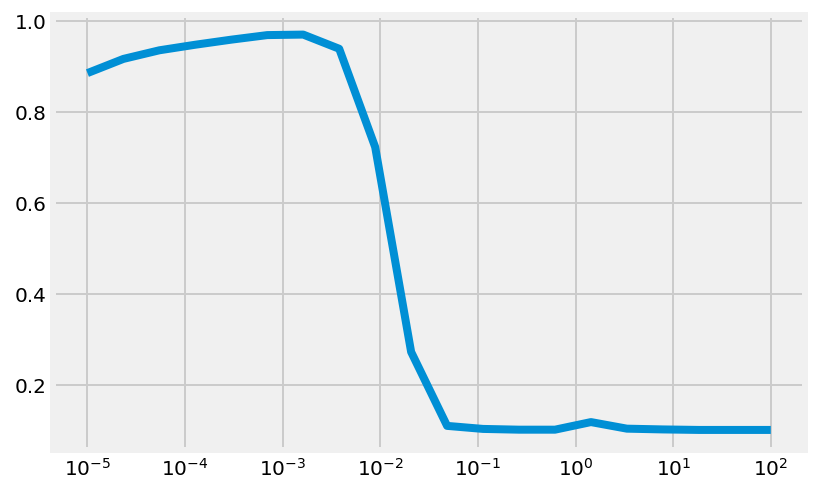

In [16]:
# plot the results
plt.plot(grid_results.param_gamma,grid_results.mean_test_score)
plt.xscale('log')
plt.show()

### 6. Gridsearch the optimal C, gamma, and kernel.

In [17]:
# Warning SUPER MEGAAA SLOWWWWW
from sklearn.model_selection import GridSearchCV
clf = svm.SVC()

gamma_range = np.logspace(-5, 2, 10)
C_range = np.logspace(-3, 2, 10)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)

grid = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid.fit(digits_X, digits_y)

# check the results of the grid search
print(grid.best_params_)
print(grid.best_score_)

best_svm = grid.best_estimator_

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
{'C': 7.742636826811277, 'gamma': 0.00035938136638046257, 'kernel': 'rbf'}
0.9721758486366165


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:  4.4min finished


### 7. Import the iris dataset.

In [18]:
# import some data to play with
iris = datasets.load_iris()
iris_X = iris.data  # we only take the first two features. 
iris_y = iris.target

In [19]:
# rescale
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
iris_X = scaler.fit_transform(iris_X)

### 8. Cross-validate a default logistic regression and default SVM on the iris data.

In [20]:
# Start with logistic Regression
X = iris_X[:,:2]
logistic = linear_model.LogisticRegression()
print(cross_val_score(logistic, X, iris_y, cv=5, scoring='accuracy').mean())


# Let's try a SVM
clf = svm.SVC()
print(cross_val_score(clf, X, iris_y, cv=5, scoring='accuracy').mean())

0.8066666666666666
0.8066666666666666


### 9. [Bonus] Compare three SVMs with different kernels on the iris data visually.
- Gaussian
- Linear
- Poly of degree 3

In [21]:
np.meshgrid(np.arange(5),np.arange(5))

[array([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]]), array([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4]])]

In [38]:
np.meshgrid(np.arange(5),np.arange(5))[0].ravel()

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1,
       2, 3, 4])

In [23]:
np.c_[np.meshgrid(np.arange(5),np.arange(5))[0].ravel(), 
      np.meshgrid(np.arange(5),np.arange(5))[1].ravel()]
#.reshape((5,10))
#.shape

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [0, 1],
       [1, 1],
       [2, 1],
       [3, 1],
       [4, 1],
       [0, 2],
       [1, 2],
       [2, 2],
       [3, 2],
       [4, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [3, 3],
       [4, 3],
       [0, 4],
       [1, 4],
       [2, 4],
       [3, 4],
       [4, 4]])

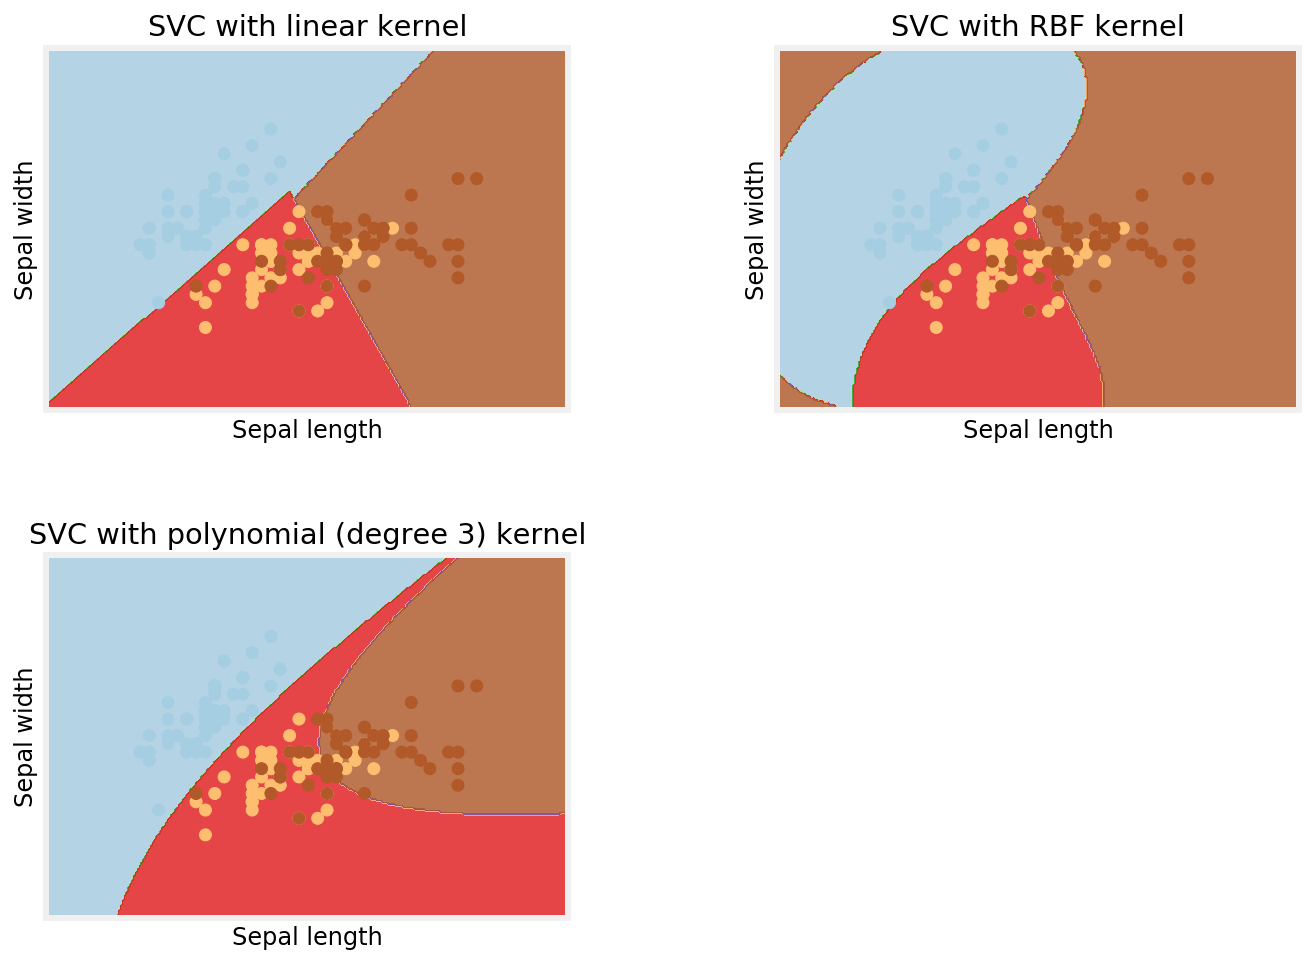

In [24]:
iris_X = iris.data[:,:2]
C = 1.0  # SVM regularization parameter
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(iris_X, iris_y)  # default kernel
svc = svm.SVC(kernel='linear', C=C).fit(iris_X, iris_y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(iris_X, iris_y)

# create a mesh to plot in
x_min, x_max = iris_X[:, 0].min() - 1, iris_X[:, 0].max() + 1
y_min, y_max = iris_X[:, 1].min() - 1, iris_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

plt.figure(figsize=(10,8))
for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    # Plot also the training points
    plt.scatter(iris_X[:, 0], iris_X[:, 1], c=iris_y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()

### 10. [Bonus] Compare SVM kernels visually on generated data using sklearn's `make_circles`.

Load `make_circles` from here:
```python
from sklearn.datasets import make_circles
```

Compare the linear, rbf, and poly kernels.

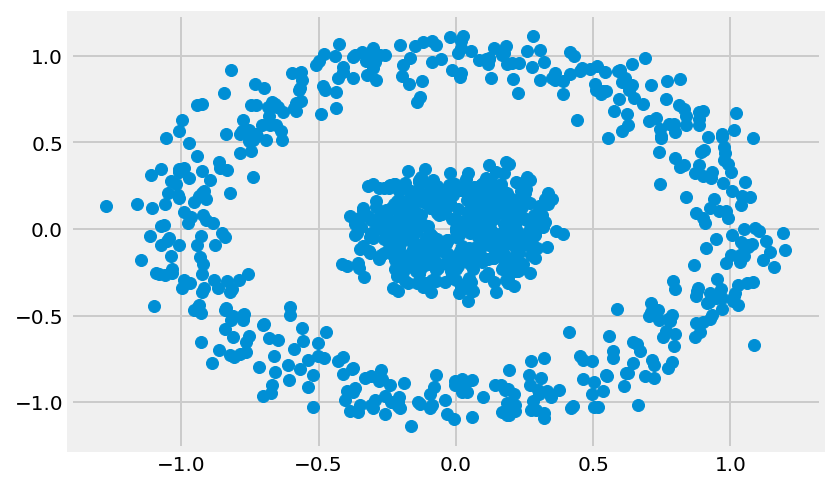

In [39]:
from sklearn.datasets import make_circles
circles_X, circles_y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(circles_X[:,0], circles_X[:,1])
plt.show()

In [40]:
# rescale
circles_X = scaler.fit_transform(circles_X)

In [41]:
# let's try to predict them without graphs
logreg = LogisticRegression()
print(cross_val_score(logreg, circles_X, circles_y, cv=5, scoring='accuracy').mean())

clf = svm.SVC(kernel = 'linear')        # I like lines
print(cross_val_score(clf, circles_X, circles_y, cv=5, scoring='accuracy').mean())


clf = svm.SVC(kernel = 'poly', degree = 3)        # I like 3rd degree polys
print(cross_val_score(clf, circles_X, circles_y, cv=5, scoring='accuracy').mean())


clf = svm.SVC(kernel = 'rbf')           # I like circles
print(cross_val_score(clf, circles_X, circles_y, cv=5, scoring='accuracy').mean())

0.489
0.652
0.626
1.0


In [42]:
# the radial basis function projects the data into higher dimensions
# that accompany circles well

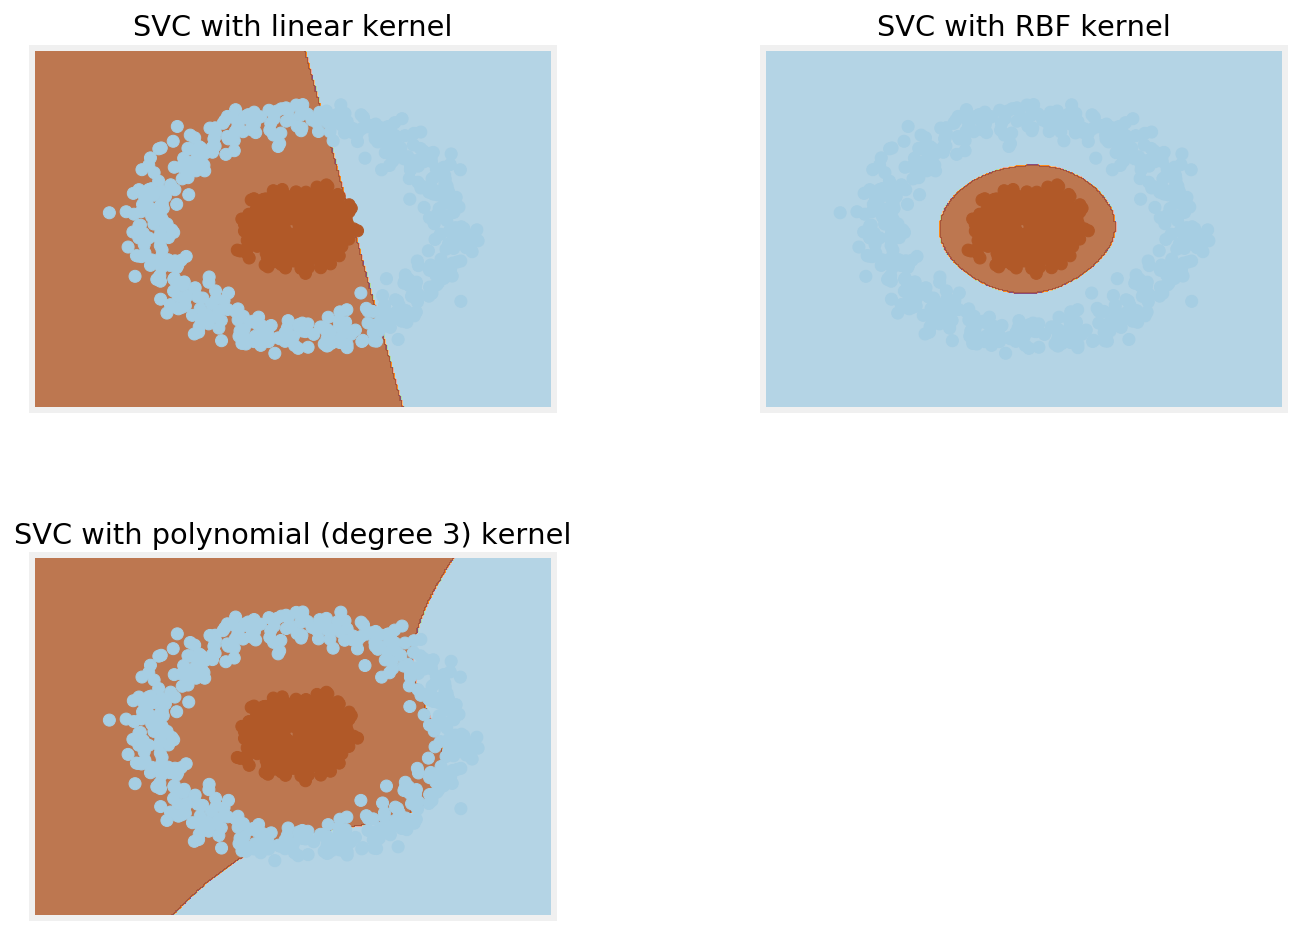

In [43]:
C = 1.0  # SVM regularization parameter
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(circles_X, circles_y)  # default kernel
svc = svm.SVC(kernel='linear', C=C).fit(circles_X, circles_y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(circles_X, circles_y)

# create a mesh to plot in
x_min, x_max = circles_X[:, 0].min() - 1, circles_X[:, 0].max() + 1
y_min, y_max = circles_X[:, 1].min() - 1, circles_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

# title for the plots
titles = ['SVC with linear kernel',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

plt.figure(figsize=(10,8))
for i, clf in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    # Plot also the training points
    plt.scatter(circles_X[:, 0], circles_X[:, 1], c=circles_y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])
plt.show()

# a real thing of beauty

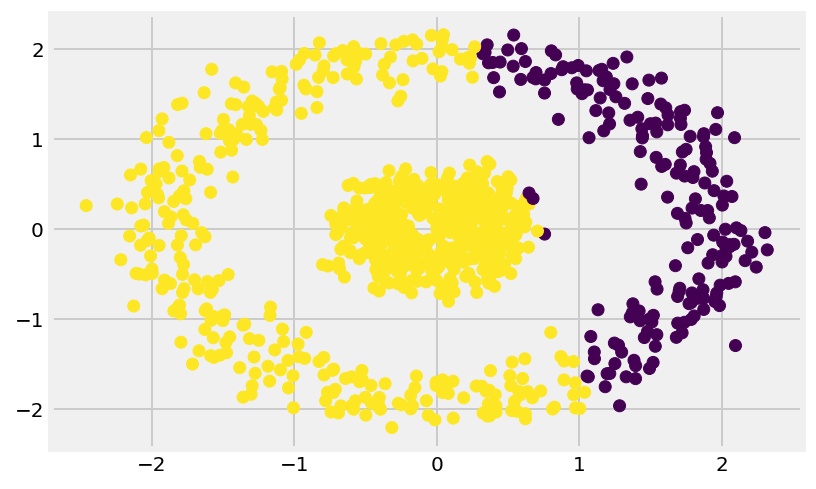

In [53]:
predictions = svc.predict(circles_X)
plt.scatter(circles_X[:,0],circles_X[:,1],c=predictions);

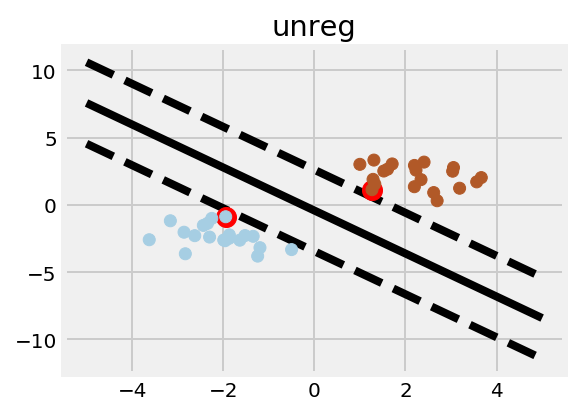

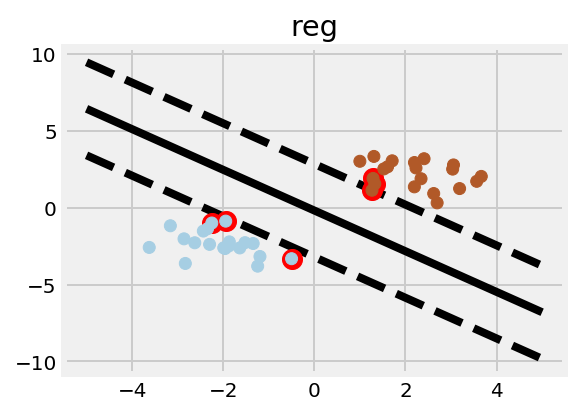

In [30]:
# Visualizing different C

X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# figure number
fignum = 1

# fit the model
for name, penalty in (('unreg', 1), ('reg', 0.05)):

    clf = svm.SVC(kernel='linear', C=penalty)
    clf.fit(X, Y)

    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(-5, 5)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy + a * margin
    yy_up = yy - a * margin

    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
                facecolors='r',marker='o', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    plt.title(name)

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

    fignum = fignum + 1

plt.show()